In [1]:
import os
import torchvision
from farabio.data.biodatasets import ChestXrayDataset, HistocancerDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import random
from skimage import io, transform
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

In [597]:
class HistocancerDataset(Dataset):
    r"""Histopathologic Cancer Dataset class
    Kaggle Histopathologic Cancer Detection dataset from [1]_
    Examples
    ----------
    >>> train_dataset = HistocancerDataset(root=".", download=True, train=True)
    >>> train_dataset.visualize_dataset()
    .. image:: ../imgs/HistocancerDataset.png
        :width: 600
    References
    ---------------
    .. [1] <https://www.kaggle.com/c/histopathologic-cancer-detection/data>`_
    """

    def __init__(self, root: str, train: bool = True, transform=None, download: bool = True):
        tag = "histopathologic-cancer-detection"

        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            self.path = os.path.join(root, tag)
        else:
            self.path = os.path.join(root)
            
        if train:
            self.csv_path = os.path.join(self.path, "train_labels.csv")
            self.img_path = os.path.join(self.path, "train")
            self.labels = pd.read_csv(self.csv_path)
            train_data, val_data = train_test_split(
                self.labels, stratify=self.labels.label, test_size=0.1)
        else:
            self.img_path = os.path.join(self.path, "test")

        self.df = train_data.values

        if transform is None:
            self.transform = self.get_train_transform
        else:
            self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    @staticmethod
    def get_train_transform(self):
        """Default transform for training data
        """
        return transforms.Compose([transforms.ToPILImage(),
                                   transforms.Pad(64, padding_mode='reflect'),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomVerticalFlip(),
                                   transforms.RandomRotation(20),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    @staticmethod
    def get_valid_transform(self):
        """Default transform for validation data
        """
        return transforms.Compose([transforms.ToPILImage(),
                                   transforms.Pad(64, padding_mode='reflect'),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    def visualize_dataset(self, n_images=10):
        fig = plt.figure(figsize=(12, 4))

        train_imgs = os.listdir(self.img_path)
        for idx, img in enumerate(np.random.choice(train_imgs, n_images)):
            ax = fig.add_subplot(2, n_images//2, idx+1, xticks=[], yticks=[])
            im = Image.open(os.path.join(self.img_path, img))
            plt.imshow(im)
            lab = self.labels.loc[self.labels['id'] ==
                                  img.split('.')[0], 'label'].values[0]
            if lab == 1:
                ax.set_title(f'{lab} = tumor')
            else:
                ax.set_title(f'{lab} = non-tumor')

In [1023]:
class HistocancerDataset(Dataset):
    r"""Histopathologic Cancer Dataset class
    Kaggle Histopathologic Cancer Detection dataset from [1]_
    Examples
    ----------
    >>> train_dataset = HistocancerDataset(root=".", download=True, train=True)
    >>> train_dataset.visualize_dataset()
    .. image:: ../imgs/HistocancerDataset.png
        :width: 600
    References
    ---------------
    .. [1] <https://www.kaggle.com/c/histopathologic-cancer-detection/data>`_
    """

    def __init__(self, root: str = ".", mode: str = "train", transform: transforms = None, target_transform: transforms = None, download: bool = True, show: bool = True):
        tag = "histopathologic-cancer-detection"
        
        modes = ["train", "val", "test"]
        assert mode in modes, "Available options for mode: train, val, test"
        
        if download:
            download_datasets(tag, path=root)
            extract_zip(os.path.join(root, tag+".zip"),
                        os.path.join(root, tag))
            self.path = os.path.join(root, tag)
        else:
            self.path = os.path.join(root)
            
        if mode == "train":
            self.csv_path = os.path.join(self.path, "train_labels.csv")
            self.img_path = os.path.join(self.path, "train")
            self.labels = pd.read_csv(self.csv_path)
            train_data, val_data = train_test_split(
                self.labels, stratify=self.labels.label, test_size=0.1)
        else:
            self.img_path = os.path.join(self.path, "test")

        self.df = train_data.values

        if transform is None:
            self.transform = self.default_transform(mode)
        else:
            self.transform = transform
        
        if show:
            self.visualize_batch()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.img_path, img_name+'.tif')
        
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

    def default_transform(self, mode):
        if mode == "train":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        elif mode == "val" or mode == "test":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
            ])

        return transform
    
    def visualize_batch(self):
        loader = DataLoader(self, batch_size=4, shuffle=True)
        imgs, labels, fnames = next(iter(loader))
        
        list_imgs = [imgs[i] for i in range(len(imgs))]
        self.show(list_imgs, fnames, labels)
            
    @staticmethod
    def show(imgs, fnames, labels):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * img + mean
            inp = np.clip(inp, 0, 1)
                        
            axs[0, i].imshow(np.asarray(inp))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if labels[i] == 0:
                lab = "non-tumor"
            else:
                lab = "tumor"
            axs[0,i].text(0,-0.2, str(int(labels[i])) + ": " + lab, fontsize=12, transform=axs[0,i].transAxes)
            axs[0,i].set_title("..."+fnames[i][-6:])

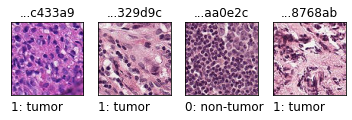

In [2]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
train_dataset = HistocancerDataset(root=_path, download=False, mode="train")

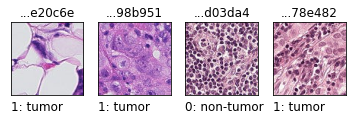

In [868]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
train_dataset = HistocancerDataset(root=_path, download=False, mode="train")

loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

imgs, labels, fnames = next(iter(loader))

def show(imgs, fnames, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        if labels[i] == 0:
            lab = "non-tumor"
        else:
            lab = "tumor"
        axs[0,i].text(0,-0.2, str(int(labels[i])) + ": " + lab, fontsize=12, transform=axs[0,i].transAxes)
        axs[0,i].set_title("..."+fnames[i][-6:])

list_imgs = [imgs[i] for i in range(len(imgs))]
show(list_imgs, fnames, labels)

In [807]:
[imgs[i] for i in range(len(imgs))]

4

In [803]:
imgs.shape

torch.Size([4, 3, 96, 96])

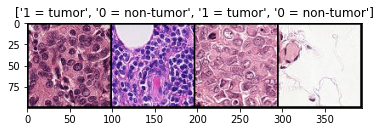

In [785]:
_path = "/home/data/02_SSD4TB/suzy/datasets/public/histopathologic-cancer-detection"
train_dataset = HistocancerDataset(root=_path, download=False, mode="train")
#train_dataset.visualize_dataset()

loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

imgs, labels = next(iter(loader))

batch_inputs = convert_image_dtype(imgs, dtype=torch.uint8)

grid = torchvision.utils.make_grid(batch_inputs)


@staticmethod
    def show(imgs, fnames):
        if not isinstance(imgs, list):
            imgs = [imgs]
        fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
        for i, img in enumerate(imgs):
            img = img.detach()
            img = F.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            axs[0,i].set_title("..."+fnames[i][-10:-4])
            
            
            
# def show(inp, label=None):
#     #fig = plt.gcf()
#     plt.imshow(inp.permute(1,2,0))
#     label_names = []
#     if label is not None:
#         for lab in label: 
#             if lab == 1:
#                 label_names.append(f'{lab} = tumor')
#             else:
#                 label_names.append(f'{lab} = non-tumor')
#         plt.title(label_names)

# show(grid, label=[int(labels[x]) for x in range(len(labels))])

#plt.imshow(grid.permute(1,2,0))


# def show(imgs, labels):
#     fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
#     for i, img in enumerate(imgs):
#         img = img.detach()
#         img = F.to_pil_image(img)
#         axs[0, i].imshow(np.asarray(img))
#         axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
#         axs[0,i].set_title("..."+labels[i])

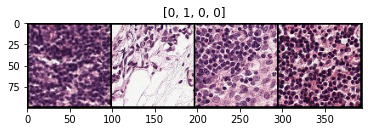

In [756]:
def show(inp, label):
    fig = plt.gcf()
    plt.imshow(inp.permute(1,2,0))
    plt.title(label)

grid = torchvision.utils.make_grid(batch_inputs)
labels = torch.tensor([0,1,0,0])

show(grid, label=[int(labels[x]) for x in range(len(labels))])

#print("done")

In [716]:
len(imgs)

4

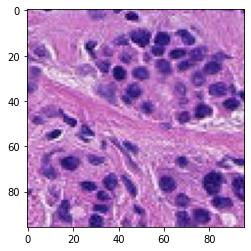

In [708]:
plt.imshow(np.asarray(imgs[0]).transpose(1,2,0))

In [643]:
imgs.dtype

torch.float32

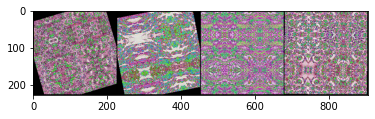

In [624]:
train_dataset

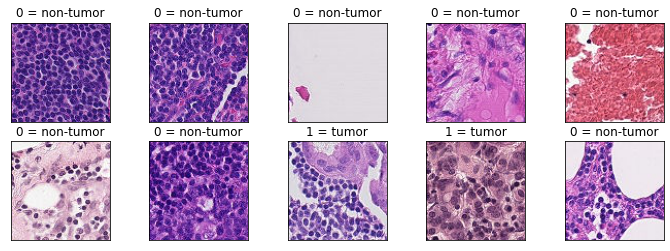

In [601]:
train_dataset.visualize_dataset()